# 데이터 전처리 방법 기초

### 무역 데이터셋을 이용하여 전처리 처리를 시행

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import os

csv_file_path = os.getenv('HOME')+'/Aiffel_Project/Dataset/trade.csv'
trade = pd.read_csv(csv_file_path) 
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,기타사항
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0,NaN
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0,NaN
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0,NaN
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0,NaN
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0,NaN


### 목표
> * **중복된 데이터를 찾아 제거**하고, **결측치(missing data)를 제거**하거나 채워 넣기.<br>
> * 데이터를 **정규화**.<br>
> * **이상치(outlier)**를 찾고 처리.<br>
> * 범주형 데이터를 **원-핫 인코딩**.<br>
>*  연속적인 데이터를 구간으로 나눠 **범주형 데이터**로 변환.


### 1. 결측치(Missing Data)부터 확인

#### 1-1. 우선 각 컬럼별로 얼마나 결측치가 있는지 파악

In [3]:
print('전체 데이터 건수:', len(trade))

# 전체 데이터 개수

전체 데이터 건수: 199


In [4]:
print('컬럼별 결측치 개수')
len(trade) - trade.count()

# 전체 데이터 개수 - 컬럼별로 값이 있는 데이터의 개수 = 컬럼별 결측치의 개수

컬럼별 결측치 개수


기간        0
국가명       0
수출건수      3
수출금액      4
수입건수      3
수입금액      3
무역수지      4
기타사항    199
dtype: int64

#### 1-2. 기타사항 컬럼이 모두 결측치이므로 컬럼을 아예 삭제

In [5]:
trade = trade.drop('기타사항', axis=1)
trade.head()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0


#### 1-3. 결측치 여부를 불리언 값으로 변환하여 결측치를 파악

 * DataFrame.isnull() : 데이터마다 결측치 여부를 True, False로 반환
 * DataFrame.any(axis=1) : 행마다 하나라도 True가 있으면 True, 그렇지 않으면 False를 반환.

In [6]:
trade.isnull()

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
194,False,False,False,False,False,False,False
195,False,False,False,False,False,False,False
196,False,False,True,True,True,True,True
197,False,False,True,True,True,True,True


In [7]:
trade.isnull().any(axis=1)

# any(axis=1) 메서드를 적용

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196     True
197     True
198     True
Length: 199, dtype: bool

In [8]:
trade[trade.isnull().any(axis=1)]

# True(결측치가 있는 행)인 데이터만 추출

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
196,2020년 06월,중국,NaN,NaN,NaN,NaN,NaN
197,2020년 06월,미국,NaN,NaN,NaN,NaN,NaN
198,2020년 06월,일본,NaN,NaN,NaN,NaN,NaN


#### 결측치가 있는 행은 파악 완료
##### 결측치를 보완하는 방법은 다양하게 있다.


> * **평균값**<br>
> * **다른 데이터**를 가져옴(대체)<br>
> * **비슷한 값**을 갖는 데이터 중 하나를 **랜덤 샘플링**하여 그 값을 복사(Hot deck imputation)
> * **Hot deck imputation과 비슷하지만** 랜덤 샘플링이 아닌 **특정 규칙을 적용**(예를 들어 k번째 샘플을 취함)(Cold deck imputation)
> * **Regression을 적용해서 예측**한 값으로 대체(대신 다양성이 떨어지게 됨, random component가 아니므로)
> * **Regression에 rendom residual(잔차) 값을 더한** 것으로 대체(random성을 보완하여 다양성을 충족)
> * 보간법(같은 대상에게 얻은 다른 관측치로 대체) - 특정한 경우만 가능

#### 현재 전처리는 간단하게 전후 데이터의 평균으로 대체할 것
**그러나 원래 이렇게 처리해서는 안 된다. (3월과 4월, 4월과 5월의 무역수지는 서로 연관이 없다.)** - domain 지식의 필요성

In [9]:
trade.loc[[188, 191, 194]]

# 우선 188, 191, 194 라벨을 가진 행을 추출

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
188,2020년 03월,미국,97117.0,7292838.0,1368345.0,5388338.0,1904500.0
191,2020년 04월,미국,105360.0,NaN,1141118.0,5038739.0,NaN
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


In [10]:
trade.loc[191, '수출금액'] = (trade.loc[188, '수출금액'] + trade.loc[194, '수출금액'] )/2
trade.loc[[191]]

# 191번 행의 수출금액 데이터를 188과 194의 평균값으로 대체

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,NaN


In [11]:
trade.loc[191, '무역수지'] = trade.loc[191, '수출금액'] - trade.loc[191, '수입금액'] 
trade.loc[[191]]

# 무역수지는 수출금액과 수입금액의 차이로 대체

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0


### 2. 중복 데이터 확인

#### trade.duplicated() 명령으로 중복 여부를 불리언 값으로 반환
#### 행을 확인 후 삭제 과정을 거칠 것


* [DataFrame.drop_duplicates 설명](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

In [12]:
trade.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196    False
197    False
198    False
Length: 199, dtype: bool

In [13]:
trade[trade.duplicated()]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


In [14]:
trade[(trade['기간']=='2020년 03월')&(trade['국가명']=='중국')]

# 중복된 행을 추출

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
186,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0
187,2020년 03월,중국,248059.0,10658599.0,358234.0,8948918.0,1709682.0


In [15]:
trade.drop_duplicates(inplace=True) 

#중복된 데이터가 삭제되면서 index가 비는 걸 방지하기 위해 inplace=True를 삽입

### 3. 이상치(Outlier) 확인

#### 단변량 자료에서 이상치를 확인하는 작업 중
#### 지금은 z-score가 특정 범위를 벗어나면 outlier로 판단하는 함수를 이용할 것
$ z score = {X - \mu \over \sigma} $

**그러나 무역 데이터란 일어난 '사실'인 만큼 특정 데이터를 이상치로 다루는 작업부터가 잘못되었다는 점을 유의** - 지금은 데이터 처리 연습을 위해 확인 

In [16]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z].index #z보다 큰 값을 return

In [17]:
trade.loc[outlier(trade, '무역수지', 1.5)]

# 1.5보다 큰 값의 인덱스를 추출

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
6,2015년 03월,중국,117529.0,11868032.0,234321.0,7226911.0,4641121.0
75,2017년 02월,중국,159062.0,11118131.0,188555.0,6600637.0,4517495.0
80,2017년 03월,일본,65093.0,2395932.0,165734.0,5157589.0,-2761657.0
96,2017년 09월,중국,183442.0,13540683.0,295443.0,8443414.0,5097269.0
99,2017년 10월,중국,137873.0,12580474.0,244977.0,7932403.0,4648071.0
101,2017년 10월,일본,63510.0,1847999.0,127696.0,4418583.0,-2570584.0
102,2017년 11월,중국,421194.0,14000887.0,307790.0,9253318.0,4747569.0
105,2017년 12월,중국,218114.0,13848364.0,290347.0,8600132.0,5248232.0
114,2018년 03월,중국,232396.0,13576667.0,267249.0,8412516.0,5164151.0
116,2018년 03월,일본,80142.0,2603450.0,159601.0,5226141.0,-2622691.0


In [18]:
trade.loc[outlier(trade, '무역수지', 2)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
129,2018년 08월,중국,199010.0,14401521.0,280033.0,8525532.0,5875989.0
132,2018년 09월,중국,171328.0,14590529.0,280337.0,7889890.0,6700639.0


In [19]:
trade.loc[outlier(trade, '무역수지', 3)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지


#### 이상치 파악 완료
##### 이상치를 보완하는 방법도 다양하게 있다.


> * **삭제**<br>
> * 다른 데이터로 **대체** - 결측치와 마찬가지로 예측 모델을 이용한 예측값으로 대체하기도 함<br>

### 현재는 이상치를 제거하는 방식을 선택
#### 이상치가 아닌 데이터만 추출하는 함수를 만들 것

In [20]:
def not_outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col]) <= z].index

In [21]:
trade.loc[not_outlier(trade, '무역수지', 1.5)]

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,116932.0,12083947.0,334522.0,8143271.0,3940676.0
1,2015년 01월,미국,65888.0,5561545.0,509564.0,3625062.0,1936484.0
2,2015년 01월,일본,54017.0,2251307.0,82480.0,3827247.0,-1575940.0
3,2015년 02월,중국,86228.0,9927642.0,209100.0,6980874.0,2946768.0
4,2015년 02월,미국,60225.0,5021264.0,428678.0,2998216.0,2023048.0
...,...,...,...,...,...,...,...
191,2020년 04월,미국,105360.0,5946782.0,1141118.0,5038739.0,908043.0
192,2020년 04월,일본,134118.0,1989323.0,141207.0,3989562.0,-2000239.0
193,2020년 05월,중국,185320.0,10746069.0,349007.0,8989920.0,1756149.0
194,2020년 05월,미국,126598.0,4600726.0,1157163.0,4286873.0,313853.0


**그러나 이상치를 찾기 위해 z-score을 사용하는 것은 몇 가지 한계점을 가짐**
> z-score은 평균과 표준편차를 이용한 계산이므로, **이미 이상치를 포함하고 있기 때문에 이상치의 영향을 받음**<br>
> 이를 보완하기 위해 중앙값과 중앙값 절대편차를 이용하는 modified Z-score도 존재(이 경우 보통 3.5를 기준으로 삼음)

### 따라서 이상치로 관측된 데이터를 제외해 나가면서 반복적으로 검정을 수행하는 과정 : **통계적 가설검정**을 사용
#### 통계적 가설 검정으로 딕슨 Q 검정, Grubbs test, Generalized ESD 검정, 카이제곱 검정 등이 있음
![이상치 탐색 방법의 분류](outlier_search.png)
(출처 : 건강보험심사평가원, 이상치 탐색을 위한 통계적 방법과 활용 방안, 2019)

### 지금은 대안이 되는 방안으로 사분위수 범위 IQR(Interquartile range)를 사용해볼 것

![IQR](IQR.jpg)
#### 사분위수 범위의 1.5배를 초과하는 관측치는 이상치. 3배를 초과하는 이상치는 극단적 이상치로 정의

In [22]:
def outlier2(df, col):
    # [[YOUR CODE]]
    Q1 = np.percentile(df[col].values, 25)
    Q3 = np.percentile(df[col].values, 75)
    IQR = Q3 - Q1

    outlier2_iqr = (((Q1-1.5*IQR) > df[col]) |((Q3+1.5*IQR) < df[col]))
    return outlier2_iqr

outlier2(trade, '무역수지')

# IQR로 이상치를 파악

0      False
1      False
2      False
3      False
4      False
       ...  
194    False
195    False
196    False
197    False
198    False
Name: 무역수지, Length: 198, dtype: bool

### 4. 정규화(Normalization)

#### 현재 무역 데이터는 수입건수, 수입금액과 수출금액, 무역수지 등 단위가 다른 데이터를 사용하고 있음
* 따라서 이러한 데이터를 클러스터링한다고 가정하면 스케일이 큰 값 영향만 받게 될 수 있음
* 마찬가지의 예로 linear regression을 해도 비슷한 상황이 발생할 것

**=> 따라서 스케일을 바꾸는 정규화를 진행**

### 1. 표준화(Standardization)
Standardization : 데이터의 평균은 0, 분산은 1로 변환</br>
### $ {X - \mu \over \sigma} $

In [23]:
cols = ['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']
trade_Standardization= (trade[cols]-trade[cols].mean())/trade[cols].std()
trade_Standardization.head()

# trade 데이터를 정규화

,수출건수,수출금액,수입건수,수입금액,무역수지
0,-0.007488,1.398931,-0.163593,1.283660,1.256342
1,-0.689278,-0.252848,0.412529,-0.964444,0.401088
2,-0.847838,-1.091156,-0.993148,-0.863844,-1.097779
3,-0.417598,0.852853,-0.576399,0.705292,0.832209
4,-0.764918,-0.389673,0.146306,-1.276341,0.438027


In [24]:
trade_Standardization.describe()

# 각 컬럼의 평균이나 표준편차 등을 확인

,수출건수,수출금액,수입건수,수입금액,무역수지
count,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02,1.950000e+02
mean,-1.019128e-16,5.921189e-17,6.091993e-17,-8.312439e-17,3.074464e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.194976e-01,-1.231761e+00,-9.984408e-01,-1.276341e+00,-1.603764e+00
25%,-5.937426e-01,-1.041338e+00,-7.673625e-01,-7.911669e-01,-1.116765e+00
50%,-4.373265e-01,-1.564700e-01,-3.429346e-01,-4.137392e-01,1.426824e-01
75%,4.420459e-01,1.037200e+00,3.927781e-01,8.827841e-01,7.461637e-01
max,5.486317e+00,2.078416e+00,3.239068e+00,2.376092e+00,2.434109e+00


#### 결과를 보면 각 컬럼의 평균이 0에 가깝고, 표준편차는 거의 1에 수렴함

### 2. Min-Max Scaling
### $ {X - X_{min} \over X_{max} - X_{min}} $

In [25]:
trade[cols] = (trade[cols]-trade[cols].min())/(trade[cols].max()-trade[cols].min())
trade.head()

# 데이터에서 최소값을 뺀 뒤, (최대값-최소값)으로 나눠줌

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지
0,2015년 01월,중국,0.142372,0.794728,0.197014,0.700903,0.708320
1,2015년 01월,미국,0.035939,0.295728,0.332972,0.085394,0.496512
2,2015년 01월,일본,0.011187,0.042477,0.001249,0.112938,0.125310
3,2015년 02월,중국,0.078351,0.629759,0.099597,0.542551,0.603281
4,2015년 02월,미국,0.024131,0.254394,0.270146,0.000000,0.505660


In [26]:
trade.describe()

,수출건수,수출금액,수입건수,수입금액,무역수지
count,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.143541,0.372113,0.235620,0.349450,0.397180
std,0.156108,0.302099,0.235988,0.273790,0.247655
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050853,0.057527,0.054532,0.132836,0.120608
50%,0.075271,0.324844,0.154691,0.236172,0.432516
75%,0.212548,0.685450,0.328311,0.591147,0.581972
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### 결과를 보면 각 컬럼의 최소값이 0이고, 최대값이 1임을 확인할 수 있음

## 주의 : train 데이터와 test 데이터를 나눈 경우 test 데이터도 정규화시키기

In [27]:
train = pd.DataFrame([[10, -10], [30, 10], [50, 0]])
test = pd.DataFrame([[0, 1], [10, 10]])

In [28]:
train_min = train.min()
train_max = train.max()

train_min_max = (train - train_min)/(train_max - train_min)
test_min_max =  (test - train_min)/(train_max - train_min)

#### test를 min-max scaling할 때도 train 정규화 기준으로 수행

In [29]:
train_min_max

,0,1
0,0.0,0.0
1,0.5,1.0
2,1.0,0.5


In [30]:
test_min_max

,0,1
0,-0.25,0.55
1,0.00,1.00


### scikit-learn의 StandardScaler, MinMaxScaler를 사용하는 방식으로 동일하게 진행

In [31]:
from sklearn.preprocessing import MinMaxScaler
train = [[10, -10], [30, 10], [50, 0]]
test = [[0, 1]]
scaler = MinMaxScaler()

In [32]:
scaler.fit_transform(train)

array([[0. , 0. ],
       [0.5, 1. ],
       [1. , 0.5]])

In [33]:
scaler.transform(test)

array([[-0.25,  0.55]])

#### 이외 로그 스케일링과 같은 더 다양한 정규화 방법이 존재 

* [데이터스케일링_로그변환](https://challenge.tistory.com/46)

### 5. 원-핫 인코딩(One-Hot Encoding)

#### 해당하는 특성을 1, 나머지는 0으로 만드는 과정
#### 현재는 국가명 문자열 데이터를 원-핫 인코딩할 것임
pandas의 get_dummies를 이용하여 손쉽게 가능

In [34]:
#trade 데이터의 국가명 컬럼 원본
print(trade['국가명'].head())  

# get_dummies를 통해 국가명 원-핫 인코딩
country = pd.get_dummies(trade['국가명'])
country.head()

0    중국
1    미국
2    일본
3    중국
4    미국
Name: 국가명, dtype: object


,미국,일본,중국
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,1,0,0


* 원-핫 인코딩을 위해 데이터프레임 trade와 바로 위에서 생성한 country를 합치기
* 이후 필요 없어진 국가명 칼럼을 제거

In [35]:
trade = pd.concat([trade, country], axis=1)
trade.head()

# pd.concat을 이용해 trade와 country를 합침

,기간,국가명,수출건수,수출금액,수입건수,수입금액,무역수지,미국,일본,중국
0,2015년 01월,중국,0.142372,0.794728,0.197014,0.700903,0.708320,0,0,1
1,2015년 01월,미국,0.035939,0.295728,0.332972,0.085394,0.496512,1,0,0
2,2015년 01월,일본,0.011187,0.042477,0.001249,0.112938,0.125310,0,1,0
3,2015년 02월,중국,0.078351,0.629759,0.099597,0.542551,0.603281,0,0,1
4,2015년 02월,미국,0.024131,0.254394,0.270146,0.000000,0.505660,1,0,0


In [36]:
trade.drop(['국가명'], axis=1, inplace=True)
trade.head()

# 국가명 컬럼 삭제

,기간,수출건수,수출금액,수입건수,수입금액,무역수지,미국,일본,중국
0,2015년 01월,0.142372,0.794728,0.197014,0.700903,0.708320,0,0,1
1,2015년 01월,0.035939,0.295728,0.332972,0.085394,0.496512,1,0,0
2,2015년 01월,0.011187,0.042477,0.001249,0.112938,0.125310,0,1,0
3,2015년 02월,0.078351,0.629759,0.099597,0.542551,0.603281,0,0,1
4,2015년 02월,0.024131,0.254394,0.270146,0.000000,0.505660,1,0,0


---



### 6. 구간화(Binning)

#### 해당하는 특성을 1, 나머지는 0으로 만드는 과정

소득 데이터가 저장된 DataFrame에서 소득을 구간별로 나눌 계획

In [37]:
salary = pd.Series([4300, 8370, 1750, 3830, 1840, 4220, 3020, 2290, 4740, 4600, 
                    2860, 3400, 4800, 4470, 2440, 4530, 4850, 4850, 4760, 4500, 
                    4640, 3000, 1880, 4880, 2240, 4750, 2750, 2810, 3100, 4290, 
                    1540, 2870, 1780, 4670, 4150, 2010, 3580, 1610, 2930, 4300, 
                    2740, 1680, 3490, 4350, 1680, 6420, 8740, 8980, 9080, 3990, 
                    4960, 3700, 9600, 9330, 5600, 4100, 1770, 8280, 3120, 1950, 
                    4210, 2020, 3820, 3170, 6330, 2570, 6940, 8610, 5060, 6370,
                    9080, 3760, 8060, 2500, 4660, 1770, 9220, 3380, 2490, 3450, 
                    1960, 7210, 5810, 9450, 8910, 3470, 7350, 8410, 7520, 9610, 
                    5150, 2630, 5610, 2750, 7050, 3350, 9450, 7140, 4170, 3090])

# 소득 데이터가 저장된 DataFrame

<AxesSubplot:>

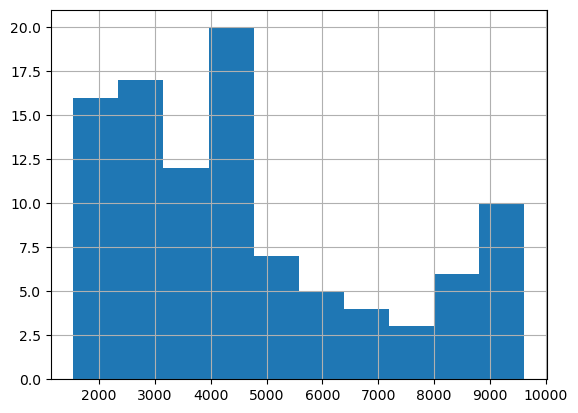

In [38]:
salary.hist()

# 히스토그램 시각화로 데이터 파악

In [39]:
bins = [0, 2000, 4000, 6000, 8000, 10000]

# 자를 구간 설정

### pandas의 cut과 qcut을 이용해 수치형 데이터를 범주형 데이터로 변경

In [40]:
ctg = pd.cut(salary, bins=bins)
ctg

0      (4000, 6000]
1     (8000, 10000]
2         (0, 2000]
3      (2000, 4000]
4         (0, 2000]
          ...      
95     (2000, 4000]
96    (8000, 10000]
97     (6000, 8000]
98     (4000, 6000]
99     (2000, 4000]
Length: 100, dtype: category
Categories (5, interval[int64, right]): [(0, 2000] < (2000, 4000] < (4000, 6000] < (6000, 8000] < (8000, 10000]]

In [41]:
# 예시로 salary[0]가 어디 속했는지 보자

print('salary[0]:', salary[0])
print('salary[0]가 속한 카테고리:', ctg[0])

salary[0]: 4300
salary[0]가 속한 카테고리: (4000, 6000]


In [42]:
ctg.value_counts().sort_index()

# 구간별로 얼마나 값이 속했는지 파악

(0, 2000]        12
(2000, 4000]     34
(4000, 6000]     29
(6000, 8000]      9
(8000, 10000]    16
dtype: int64

#### + 리스트 대신 bins 옵션에 정수를 입력하면, (최대값-최소값) 구역을 균등하게 정수 개수만큼의 구간으로 나눠 줌

In [43]:
ctg = pd.cut(salary, bins=6)
ctg

0      (4230.0, 5575.0]
1      (8265.0, 9610.0]
2     (1531.93, 2885.0]
3      (2885.0, 4230.0]
4     (1531.93, 2885.0]
            ...        
95     (2885.0, 4230.0]
96     (8265.0, 9610.0]
97     (6920.0, 8265.0]
98     (2885.0, 4230.0]
99     (2885.0, 4230.0]
Length: 100, dtype: category
Categories (6, interval[float64, right]): [(1531.93, 2885.0] < (2885.0, 4230.0] < (4230.0, 5575.0] < (5575.0, 6920.0] < (6920.0, 8265.0] < (8265.0, 9610.0]]

In [44]:
ctg.value_counts().sort_index()

(1531.93, 2885.0]    27
(2885.0, 4230.0]     24
(4230.0, 5575.0]     21
(5575.0, 6920.0]      6
(6920.0, 8265.0]      7
(8265.0, 9610.0]     15
dtype: int64

#### + qcut을 사용하면 데이터의 분포를 비슷한 개수 그룹으로 나누어 줌

In [45]:
ctg = pd.qcut(salary, q=5)
ctg

0       (3544.0, 4648.0]
1       (7068.0, 9610.0]
2     (1539.999, 2618.0]
3       (3544.0, 4648.0]
4     (1539.999, 2618.0]
             ...        
95      (2618.0, 3544.0]
96      (7068.0, 9610.0]
97      (7068.0, 9610.0]
98      (3544.0, 4648.0]
99      (2618.0, 3544.0]
Length: 100, dtype: category
Categories (5, interval[float64, right]): [(1539.999, 2618.0] < (2618.0, 3544.0] < (3544.0, 4648.0] < (4648.0, 7068.0] < (7068.0, 9610.0]]

In [46]:
print(ctg.value_counts().sort_index())

(1539.999, 2618.0]    20
(2618.0, 3544.0]      20
(3544.0, 4648.0]      20
(4648.0, 7068.0]      20
(7068.0, 9610.0]      20
dtype: int64
